# 样式迁移

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
%matplotlib inline

In [5]:
import mxnet as mx
import d2lzh as d2l
from mxnet import nd,gluon,contrib,image,autograd,init
from mxnet.gluon import data as gdata,loss as gloss,nn,model_zoo
import gluonbook as gb
import time

## 读取内容图像和样式图像

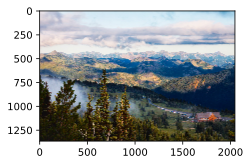

In [6]:
%matplotlib inline
d2l.set_figsize()
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy())

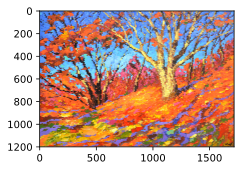

In [7]:
style_img = image.imread('../img/autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy())

## 预处理和后处理图像

* 预处理函数preprocess对输入图像在RGB三个通道分别作标准化。并将结果变换成卷积神经网络接受的输入格式。后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。由于图像打印函数要求每个像素的浮点数值在0到1之间，我们使用clip函数对小于0和大于1的值分别取0和1

In [8]:
rgb_mean = nd.array([0.485,0.456,0.406])
rgb_std = nd.array([0.229,0.224,0.225])

def preprocess(img,image_shape):
    img = image.imresize(img,*image_shape)
    img = (img.astype('float32')/255-rgb_mean)/rgb_std
    return img.transpose((2,0,1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_mean.context)
    return (img.transpose((1,2,0))*rgb_std+rgb_mean).clip(0,1)

## 抽取特征

* 使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征

In [9]:
pretrained_model = model_zoo.vision.vgg19(pretrained=True,root='../data')

为了抽取图像的内容特征和样式特征，我们可以选择VGG网络中的某些层的输出。一般来说，越靠近输入层的输出越容易抽取图像的细节信息，反之则越容易抽取图像的全局信息。为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，也称内容层，来输出图像的内容特征。我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些层也叫样式层。

In [10]:
print(pretrained_model)

VGG(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Activation(relu)
    (16): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
style_layers,content_layers = [0,5,10,19,28],[25]

在抽取特征时，我们只需要用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层。下面构建一个新的net

In [12]:
net = nn.Sequential()

In [13]:
for i in range(max(content_layers + style_layers)+1):
    net.add(pretrained_model.features[i])

给定输入X，如果简单调用前向计算net(x)，只能获得最后一层的输出。由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和样式层的输出

In [14]:
def extract_features(X,content_layers,style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents,styles

下面定义两个函数，其中get_contents函数对内容图像抽取内容特征，而get_styles函数则对样式图像抽取样式特征。因为在训练时无需改变预训练的VGG的模型参数，所以我们可在训练开始之前就提取出内容图像的内容特征，以及样式图像的样式特征。由于合成图像是样式迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和样式特征。

In [15]:
def get_contents(image_shape,ctx):
    content_X = preprocess(content_img,image_shape).copyto(ctx)
    contents_Y,_ = extract_features(content_X,content_layers,style_layers)
    return content_X,contents_Y

def get_styles(image_shape,ctx):
    style_X = preprocess(style_img,image_shape).copyto(ctx)
    _,styles_Y = extract_features(style_X,content_layers,style_layers)
    return style_X,styles_Y

## 定义损失函数

* 下面我们来描述样式迁移的损失函数。它由内容损失、样式损失和总变差损失3部分组成

### 内容损失

* 与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。平方误差函数的两个输入居委extract_features函数计算所得到的内容层的输出

In [16]:
def content_loss(Y_hat,Y):
    return (Y_hat-Y).square().mean()

### 样式损失

样式损失也一样通过平方误差函数衡量合成图像与样式图像在样式上的差异。为了表达样式层输出的样式，我们先通过extract_features函数计算样式层的输出。

In [17]:
def gram(X):
    num_channels,n = X.shape[1],X.size // X.shape[1]
    X = X.reshape((num_channels,n))
    return nd.dot(X,X.T) / (num_channels*n)

def style_loss(Y_hat,gram_Y):
    return (gram(Y_hat)-gram_Y).square().mean()

### 总变差损失

有时候，我们学到的合成图像里面有大量的高频噪点，即有特别亮或者特别暗的颗粒像素。一种常用的降噪方法是总变差降噪。假设$x_{i,j}$表示坐标为$(i,j)$的像素值，降低总变差损失
$$
\sum_{i,j}|x_{i,j}-x_{i+1,j}|+|x_{i,j}-x_{i,j+1}|
$$
能够尽可能使相邻近的像素值相似

In [18]:
def tv_loss(Y_hat):
    return 0.5*((Y_hat[:,:,1:,:]-Y_hat[:,:,:-1,:]).abs().mean()+
               (Y_hat[:,:,:,1:]-Y_hat[:,:,:,:-1]).abs().mean())

### 损失函数

样式迁移的损失函数即内容损失、样式损失和总变差损失的加权和。通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性

In [19]:
content_weight,style_weight,tv_weight = 1,1e3,10

In [20]:
def compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram):
    #分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat,Y)*content_weight for Y_hat,Y in zip(contents_Y_hat,contents_Y)]
    styles_l = [style_loss(Y_hat,Y)*style_weight for Y_hat,Y in zip(styles_Y_hat,styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    #对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l,styles_l,tv_l,l

## 创建和初始化合成图像

在样式迁移中，合成图像是唯一需要更新的变量。因此，我们可以定义一个简单的模型GeneratedImage，并将合成图像视为模型参数。模型的前向计算只需返回模型参数即可

In [21]:
class GeneratedImage(nn.Block):
    def __init__(self,img_shape,**kwargs):
        super(GeneratedImage,self).__init__(**kwargs)
        self.weight = self.params.get('weight',shape=img_shape)
    def forward(self):
        return self.weight.data()

下面，我们定义get_inits函数。该函数创建了合成图像的模型实例，并将其初始化为图像X。样式图像在各个样式层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。

In [28]:
def get_inits(X,ctx,lr,styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X),ctx=ctx,force_reinit =True)
    trainer = gluon.Trainer(gen_img.collect_params(),'adam',
                           {'learning_rate':lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(),styles_Y_gram,trainer

## 训练

In [33]:
def train(X,contents_Y,styles_Y,ctx,lr,max_epochs,lr_decay_epoch):
    X,styles_Y_gram,trainer = get_inits(X,ctx,lr,styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat,styles_Y_hat = extract_features(
                X,content_layers,style_layers)
            contents_l,styles_l,tv_l,l = compute_loss(
                X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i%50 == 0 and i != 0:
            print('epoch %3d,content loss %.2f,stlye loss %.2f,'
                 'TV loss %.2f, %.2f sec'%
                  (i,nd.add_n(*contents_l).asscalar(),
                  nd.add_n(*styles_l).asscalar(),tv_l.asscalar(),
                  time.time()-start))
        if i%lr_decay_epoch == 0 and i!= 0:
            trainer.set_learning_rate(trainer.learning_rate*0.1)
            print('change lr to %.1e'%trainer.learning_rate)
    return X


下面我们开始训练模型。首先将内容图像和样式图像的高和宽分别调整为150和255像素。合成图像将由内容图像来初始化。

In [34]:
ctx,image_shape = d2l.try_gpu(),(225,150)
net.collect_params().reset_ctx(ctx)
content_X,contents_Y = get_contents(image_shape,ctx)
_,styles_Y = get_styles(image_shape,ctx)
output = train(content_X,contents_Y,styles_Y,ctx,0.01,500,200)

epoch  50,content loss 9.98,stlye loss 29.08,TV loss 3.48, 0.07 sec
epoch 100,content loss 7.44,stlye loss 15.23,TV loss 3.90, 0.07 sec
epoch 150,content loss 6.29,stlye loss 10.26,TV loss 4.15, 0.08 sec
epoch 200,content loss 5.63,stlye loss 8.05,TV loss 4.28, 0.08 sec
change lr to 1.0e-03
epoch 250,content loss 5.56,stlye loss 7.88,TV loss 4.29, 0.06 sec
epoch 300,content loss 5.50,stlye loss 7.74,TV loss 4.30, 0.07 sec
epoch 350,content loss 5.44,stlye loss 7.60,TV loss 4.30, 0.07 sec
epoch 400,content loss 5.38,stlye loss 7.46,TV loss 4.31, 0.07 sec
change lr to 1.0e-04
epoch 450,content loss 5.37,stlye loss 7.44,TV loss 4.31, 0.09 sec


In [36]:
d2l.plt.imsave('./neural1.png',postprocess(output).asnumpy())

In [38]:
image_shape = (450,300)
_,content_Y = get_contents(image_shape,ctx)
_,style_Y = get_styles(image_shape,ctx)
X  = preprocess(postprocess(output)*255,image_shape)
output = train(X,content_Y,style_Y,ctx,0.01,300,100)
d2l.plt.imsave('./neral2.png',postprocess(output).asnumpy())

epoch  50,content loss 13.92,stlye loss 13.70,TV loss 2.37, 0.25 sec
epoch 100,content loss 9.60,stlye loss 8.75,TV loss 2.65, 0.25 sec
change lr to 1.0e-03
epoch 150,content loss 9.29,stlye loss 8.43,TV loss 2.67, 0.24 sec
epoch 200,content loss 9.01,stlye loss 8.14,TV loss 2.69, 0.25 sec
change lr to 1.0e-04
epoch 250,content loss 8.98,stlye loss 8.11,TV loss 2.69, 0.26 sec
